# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [851]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import random

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
df.shape

(45993, 3)

In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [5]:
df_content.shape

(1056, 5)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [31]:
# Let's look at how many articles a user interacts with
df.groupby('email').article_id.nunique().sort_values()

email
55ff95ae8c771735bcacbaa323c490fea1fbe0be      1
c5043620e39033e492ca3db285ba647b4b3022ce      1
7e1d2be90b278dbe75951826c2f233917161e176      1
7e1d7268e6bfb831bfb565cc44bb136e5ab15476      1
7e52303f9d7298157a365c8641f6a162e24ddfd6      1
                                           ... 
a37adec71b667b297ed2440a9ff7dad427c7ac85     97
c60bb0a50c324dad0bffd8809d121246baef372b    100
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    101
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    135
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    135
Name: article_id, Length: 5148, dtype: int64

In [38]:
from statistics import mode
print("average articles is", df.groupby('email').article_id.nunique().mean())
print("most frequent is",mode(df.groupby('email').article_id.nunique().tolist()))

average articles is 6.54020979020979
most frequent is 1


What is the distribution of how many articles a user interacts with in the dataset?
- minimum is 1 (by construction)
- maximum is 135 (2 users)
- average is 6.5 articles
- Most frequent is 1

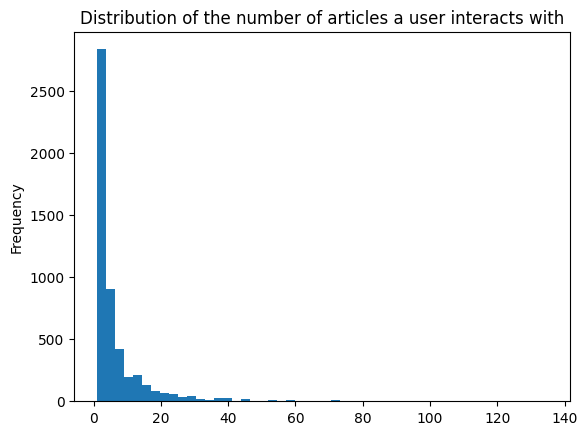

In [52]:
# Distribution of the number of articles a user interacts with
df.groupby('email').article_id.nunique().plot(kind='hist', bins=50)
plt.title("Distribution of the number of articles a user interacts with");

Number of times each user interacts with an article ?

In [45]:
df.groupby(['email','article_id']).count()

title
email                                    article_id       
0000b6387a0366322d7fbfc6434af145adf7fed1 43.0            2
                                         124.0           1
                                         173.0           1
                                         288.0           1
                                         349.0           1
...                                                    ...
fffb93a166547448a0ff0232558118d59395fecd 981.0           1
                                         1304.0          1
                                         1305.0          8
                                         1430.0          1
                                         1437.0          1

[33669 rows x 1 columns]

- we can see that a user (characterized by its email) can access multiple times the same document (characterized by its unique article_id)

In [22]:
# duplicated records, ie same user accessing same article multiple times
df.duplicated().sum()

12311

In [18]:
# Here we see users accessing same article_id multiple times with a maximum of 42 times
df.groupby(['email','article_id']).count().sort_values(by='title')

title
email                                    article_id       
7c8043f352652a25d230b62c032e6c9fa4ba4e17 136.0           1
9ffa0306b74ef5e440385df79c08a7b4af95f2d0 1165.0          1
                                         844.0           1
                                         723.0           1
                                         112.0           1
...                                                    ...
c8afd6f4620184042cc48ca0eba9a657ac89e90e 1429.0         25
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a 1429.0         35
2b6c0f514c2f2b04ad3c4583407dccd0810469ee 1429.0         35
363cb98a087e4a3eb6890fd1af2d418116f85ff8 1170.0         41
1588af175b283915f597fc4719cbb2c8621c4fc2 1170.0         42

[33669 rows x 1 columns]

In [20]:
# Let's look at one example of a user: which article_ids he got access to and how many times for each of these article_id ?
df[df.email=='2b6c0f514c2f2b04ad3c4583407dccd0810469ee'].value_counts(subset='article_id')

article_id
1429.0    35
1293.0    16
29.0      15
43.0      15
1172.0    12
          ..
634.0      1
617.0      1
524.0      1
517.0      1
1439.0     1
Length: 135, dtype: int64

In [53]:
print("Average article access is",df.groupby(['email','article_id']).count().title.mean())
print("most frequent is",mode(df.groupby(['email','article_id']).count().title.tolist()))

Average article access is 1.3655291217440375
most frequent is 1


What is the distribution of how many times a user interacts with an article in the dataset?
- minimum is 1 (by construction)
- maximum is 42 (1 user)
- average is 1.4 times per article
- Most frequent is 1

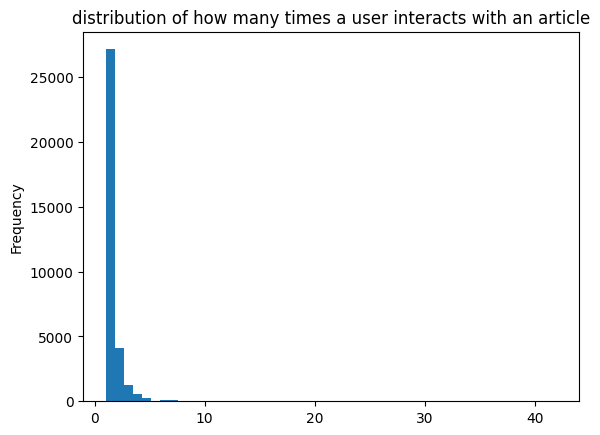

In [51]:
df.groupby(['email','article_id']).count().title.plot(kind='hist', bins=50)
plt.title("distribution of how many times a user interacts with an article");

In [6]:
# Fill in the median and maximum number of user_article interactios below

median_val = df.groupby('email').article_id.nunique().median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.groupby('email').article_id.count().max() # The maximum number of user-article interactions by any 1 user is ______.

In [58]:
print(f"50% of individuals interact with {median_val} articles or fewer")
print(f"The maximum number of user-article interactions by any 1 user is {max_views_by_user} different articles")

50% of individuals interact with 3.0 articles or fewer
The maximum number of user-article interactions by any 1 user is 135 different articles


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [852]:
# Find and explore duplicate articles
df_content.duplicated(subset='article_id').sum()

5

there are 5 entries with identical 'article_id' which are the following:

In [853]:
df_content.loc[df_content.duplicated(subset='article_id', keep=False),:].sort_values(by='article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [854]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset='article_id', keep='first')
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [86]:

# article - user interactions
df.groupby(['article_id','email']).count()

title
article_id email                                          
0.0        2841916b462a2b89d36f4f95ca2d1f42559a5788      1
           384255292a8223e84f05ca1e1deaa450c993e148      3
           451a9a4a4cb1cc4e5f38d04e8859cc3fb275cc66      1
           74ca1ae8b034f7fad73a54d55fb1f58747f00493      1
           8bd0afc488016810c287ac4ec844895d570b0af4      1
...                                                    ...
1444.0     6cce7568da5452718e1a3702edffac34a8da74ec      1
           c45f9495a76bf95d2633444817f1be8205ad542d      1
           d313c83ab3ed388ba16042a6cd33fce57d6a9e9a      1
           d5843ed71361c87b364f578f20a48101289d60f9      1
           fd824fc62b4753107e3db7704cd9e8a4a1c961f1      1

[33669 rows x 1 columns]

In [15]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = len(df_content) # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = len(df) # The number of user-article interactions

In [16]:
print(f"The number of unique articles that have at least one interaction = {unique_articles}")
print(f"The number of unique articles on the IBM platform = {total_articles}")
print(f"The number of unique users = {unique_users}")
print(f"The number of user-article interactions = {user_article_interactions}")

The number of unique articles that have at least one interaction = 714
The number of unique articles on the IBM platform = 1051
The number of unique users = 5148
The number of user-article interactions = 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [102]:
df.groupby('article_id').email.count().sort_values(ascending=False)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
         ... 
1113.0      1
1119.0      1
984.0       1
1127.0      1
1266.0      1
Name: email, Length: 714, dtype: int64

In [103]:
df[df.article_id==1429]

,article_id,title,email
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
6,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
41,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
75,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
80,1429.0,use deep learning for image classification,d385b6c44711688ce2a33eb596495bf9243e1750
...,...,...,...
45147,1429.0,use deep learning for image classification,6edb515f6b2b4fcb369b119afcc1b26d9c2f87a4
45153,1429.0,use deep learning for image classification,6edb515f6b2b4fcb369b119afcc1b26d9c2f87a4
45156,1429.0,use deep learning for image classification,6edb515f6b2b4fcb369b119afcc1b26d9c2f87a4
45190,1429.0,use deep learning for image classification,7aef8f14001f95da4a76c810970d4aa469cdf11f


In [10]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [108]:
print(f"The most viewed article in the dataset is article_id {most_viewed_article_id}: {df[df.article_id==1429].title.unique()[0]}")
print(f"Number of views of the most viewed article in the dataset = {df.groupby('article_id').email.count().sort_values(ascending=False).max()}")

The most viewed article in the dataset is article_id 1429.0: use deep learning for image classification
Number of views of the most viewed article in the dataset = 937


In [18]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [20]:
df.shape

(45993, 3)

In [17]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [291]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_n_sorted_ids = df.groupby('article_id').user_id.count().sort_values(ascending=False).index.tolist()[:n]
    top_articles = df[df.article_id.isin(top_n_sorted_ids)]['title'].values

    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Your code here
    top_articles = df.groupby('article_id').user_id.count().sort_values(ascending=False).index.tolist()[:n]
    top_articles = [str(t) for t in top_articles]

    return top_articles # Return the top article ids

In [292]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo'
 'use deep learning for image classification'
 'use deep learning for image classification' ...
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'insights from new york car accident reports']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [293]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [75]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    # Create user-by-item matrix
    user_items = df[['user_id', 'article_id', 'title']]
    user_item = user_items.groupby(['user_id', 'article_id'])['title'].apply(lambda x: 1).unstack()
    user_item = user_item.fillna(0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [76]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [207]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarities = np.dot(user_item.loc[user_id,:], user_item.T)

    # sort by similarity
    ordered_idx = np.argsort(similarities)[::-1]

    # create list of just the ids
    most_similar_users = list(user_item.index[ordered_idx])
    
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [208]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [209]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    subset = df[['article_id', 'title']].drop_duplicates().astype(str)
    article_names = []
    for id in article_ids:
        article_names.append(subset[subset.article_id==id].title.values[0])  #= subset[subset.article_id.isin(article_ids)].title.tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.columns[user_item.loc[user_id,:]>0].astype(str).tolist()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    # collect articles already read by target user
    read_articles_ids, _ = get_user_articles(user_id)
    # find most similar users to target user
    most_similar_users = find_similar_users(user_id)
    # will be used to store recommendation list of article ids
    recs = []
    # for each user nearest to the target user
    # Do not incorporate list.shuffle for randomized selection 
    # because ordered from closest to farest
    for user in most_similar_users:  
        # calculate remaining number of articles to select
        recos_left = m - len(recs)
        # get articles read by current nearest user
        article_ids, _ = get_user_articles(user)
        # remove articles already read by target user
        article_ids = [id for id in article_ids if id not in read_articles_ids]
        # if we have less articles than what we need to find then add them all
        # to the recommendation list
        if len(article_ids) <= recos_left:
            recs.extend(article_ids)
        else:
            # if we find more articles than needed,
            # randomly select the remaining articles making up to m number,
            # then break out of the loop to terminate search
            recs.extend(random.sample(article_ids, recos_left))
            break    
    
    return recs # return your recommendations for this user_id    

In [212]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['healthcare python streaming application demo',
 'brunel 2.0 preview',
 'automating web analytics through python',
 'pixiedust 1.0 is here! – ibm watson data lab',
 'times world university ranking analysis',
 'analyze accident reports on amazon emr spark',
 'ml optimization using cognitive assistant',
 'analyze open data sets with spark & pixiedust',
 'shaping data with ibm data refinery',
 'build a python app on the streaming analytics service']

In [213]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [278]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    # compute similarity of each user to the provided user
    similarities = np.dot(user_item.loc[user_id,:], user_item.T)

    # sort by similarity (highest to lowest)
    ordered_idx = np.argsort(similarities)[::-1]

    # create list of just the ids and corresponding similarities
    most_similar_users = list(user_item.index[ordered_idx])
    ordered_similarities = list(np.sort(similarities)[::-1])
    
    # remove the own user's id and similarity (should be the 1st and higest one)
    user_idx = most_similar_users.index(user_id)
    most_similar_users.remove(user_id)
    ordered_similarities.pop(user_idx)

    # get interactions
    interactions_per_user = user_item.loc[most_similar_users,:].sum(axis=1).values

    # summarize information into a dataframe
    neighbors_df = pd.DataFrame({'neighbor_id':most_similar_users, 'similarity':ordered_similarities, 'num_interactions': interactions_per_user})

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recs = []
    # collect articles already read by target user
    read_articles_ids, _ = get_user_articles(user_id)
    neighbors_df = get_top_sorted_users(user_id)
    neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=False, inplace=True)
    similarities = neighbors_df.similarity.tolist()  #.sort_values(ascending=False)

    for similarity in similarities:
        subset = neighbors_df[neighbors_df.similarity==similarity]
        neighbor_ids = subset.neighbor_id.tolist()
        lst_article_ids = set()
        for neighbor_id in neighbor_ids:
            # get articles read by current nearest user
            article_ids, _ = get_user_articles(neighbor_id)
            # remove articles already read by target user
            article_ids = [float(id) for id in article_ids if id not in read_articles_ids]

            if len(article_ids)>0:
                lst_article_ids.update(article_ids)

        if len(lst_article_ids)>0:
            lst_article_ids = list(lst_article_ids)
            # get articles interactions
            interactions_per_article = user_item.loc[:,lst_article_ids].sum(axis=0).values
            sorted_interactions_idx = np.argsort(interactions_per_article)[::-1]
            sorted_articles_ids = [lst_article_ids[i] for i in sorted_interactions_idx]

            remaining_articles_to_find = m - len(recs)
            if len(sorted_articles_ids)>=remaining_articles_to_find:
                recs.extend(sorted_articles_ids[:remaining_articles_to_find])
                break
            else:
                recs.extend(sorted_articles_ids)
    
    recs = [str(i) for i in recs]
    rec_names = get_article_names(recs)       
    
    return recs, rec_names

In [280]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1429.0', '1364.0', '1314.0', '1431.0', '1271.0', '1427.0', '43.0', '1160.0', '1351.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use deep learning for image classification', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'visualize car data with brunel', 'customer demographics and sales', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'deep learning with tensorflow course by big data university', 'analyze accident reports on amazon emr spark', 'model bike sharing data with spss']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [281]:
get_top_sorted_users(1)

,neighbor_id,similarity,num_interactions
0,3933,35.0,35.0
1,23,17.0,135.0
2,3782,17.0,135.0
3,203,15.0,96.0
4,4459,15.0,96.0
...,...,...,...
5143,2920,0.0,2.0
5144,2918,0.0,1.0
5145,2916,0.0,5.0
5146,2911,0.0,9.0


In [282]:
get_top_sorted_users(131).head(10)

,neighbor_id,similarity,num_interactions
0,3870,74.0,75.0
1,3782,39.0,135.0
2,23,38.0,135.0
3,4459,33.0,96.0
4,203,33.0,96.0
5,98,29.0,97.0
6,3764,29.0,97.0
7,3697,29.0,100.0
8,49,29.0,101.0
9,242,25.0,59.0


In [283]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [284]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

a new user won't have any neighbors since he will not have user-article interactions to compare yet. Therefore
- a rank-based approach could overcome this issue. We could use get_top_articles to submit a initial recommendation without knowing what the new user in interested in
- We could also add a filtering step if the user has provided areas of interests when joining the platform
- by asking areas of interest from users, we could find a first set of neighbors using users with similar areas of interests and selecting articles with highest interactions from these users. This would be a initial approach similar to user_user_recs_part2 above however using a different similarity calculation base (user areas of interests)

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [322]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to a new user

def rank_article_ids(article_ids):
    '''
    return a list of article_ids sorted by number of interactions
    input:
    - list of article_ids
    output:
    - same list of article_ids sorted by interactions (highest to lowest)
    '''
    # sort article_ids by highest to lowest interactions
    ranked_article_ids = user_item.loc[:,article_ids].sum(axis=0).sort_values(ascending=False).index.tolist()
    return ranked_article_ids


top_article_ids_str = get_top_article_ids(10)
top_article_ids_digit = [float(id) for id in top_article_ids_str]
new_user_recs = rank_article_ids(top_article_ids_digit) # Your recommendations here
new_user_recs = [str(id) for id in new_user_recs]
get_article_names(new_user_recs) 



['insights from new york car accident reports',
 'use deep learning for image classification',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for logistic regression model',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'finding optimal locations of new store using decision optimization']

In [323]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [1004]:
# Import NLP libraries
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from tqdm import tqdm
tqdm.pandas()
import re
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [855]:
def clean(tokens):
        ''' 
        Remove stopwords, lemmatize tokens, convert to lowercase
        Input:
        - list of string tokens

        Output:
        - cleaned string: lemmatized tokens converted to a string without stopwords
        '''
        tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens if w.lower() not in stop_words]
        tokens = [lemmatizer.lemmatize(w.lower(), pos='v') for w in tokens]
        return ' '.join(tokens)


# Perform text cleasing:
# replace empty fields by empty string
df_content[['doc_body', 'doc_description', 'doc_full_name']].fillna('', inplace=True)
# convert input to string
df_content[['doc_body', 'doc_description', 'doc_full_name']] = df_content[['doc_body', 'doc_description', 'doc_full_name']].astype(str)
# remove http adresses
df_content['cleaned_text'] = df_content['doc_description'].progress_apply(lambda text: re.sub(r'http\S+', '', text))
df_content['cleaned_text'] = df_content['cleaned_text'].progress_apply(lambda text: ''.join(text.splitlines()))
# remove all characters other than alpha and space. Remove all punctuations
df_content['cleaned_text'] = df_content['cleaned_text'].progress_apply(lambda text: re.sub("[^A-Za-z ]", "", text))
# tokenize
df_content['tokenized'] = df_content.cleaned_text.progress_apply(word_tokenize)
# remove stopwords and lemmatize
df_content['cleaned_text'] = df_content['tokenized'].progress_apply(clean)

C:\Users\lveys\AppData\Local\Temp\ipykernel_43756\3307046189.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_content[['doc_body', 'doc_description', 'doc_full_name']].fillna('', inplace=True)
100%|██████████| 1051/1051 [00:00<00:00, 5971.57it/s]


- IMPORTANT REMINDER: df_content duplicated entries removed in data exploration phase earlier above

In [856]:
# set article_id as index
print(df_content.shape, df_content.article_id.nunique())
df_content.set_index('article_id', inplace=True)

((1051, 7), 1051)

In [858]:
df_content

,doc_body,doc_description,doc_full_name,doc_status,cleaned_text,tokenized
article_id,,,,,,
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,detect bad read real time use python stream an...,"[Detect, bad, readings, in, real, time, using,..."
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,see forest see tree lie challenge perform pres...,"[See, the, forest, see, the, trees, Here, lies..."
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,here week news data science big data,"[Heres, this, weeks, news, in, Data, Science, ..."
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,learn distribute db solve problem scale persis...,"[Learn, how, distributed, DBs, solve, the, pro..."
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,video demonstrate power ibm datascience experi...,"[This, video, demonstrates, the, power, of, IB..."
...,...,...,...,...,...,...
1046,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,pouchdb us mapreduce default search mechanism ...,"[PouchDB, uses, MapReduce, as, its, default, s..."
1047,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,compare discriminative generative learn typify...,"[We, compare, discriminative, and, generative,..."
1048,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,order demystify magic behind machine learn alg...,"[In, order, to, demystify, some, of, the, magi..."


In [887]:
# get bag of words features in sparse format
#cv = CountVectorizer(min_df=2, max_df=0.8)
cv = TfidfVectorizer(min_df=4, max_df=0.7)
cv_matrix = cv.fit_transform(df_content['cleaned_text'].values)
cv_matrix.shape

(1051, 831)

In [888]:
# view dense representation
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [889]:
# get all unique words in the corpus
vocab = cv.get_feature_names_out()
# show document feature vectors
matrix_df = pd.DataFrame(cv_matrix, columns=vocab)
matrix_df

,ability,able,access,accessible,account,across,action,actual,actually,add,...,work,world,worry,would,write,year,york,youll,youre,youve
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.412032,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.147485,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [1017]:
def make_content_recs(id, kind='article', k=5):
    '''
    Article_id:
    - return top k most similar articles compared to target article_id
    using dot product on tokenization vectors using tfIdf vectorizer
    New user_id:
    - return the top k articles by popularity

    INPUT:
        - id (int or str): target article_id or user_id
        - kind (str): 'article' or 'user'
        - k (int): number of most similar articles to return
    OUTPUT:
        - For article: dataframe of top k most similar articles sorted by 
        decreasing similarity
        - For user: top k titles ranked by interactions
    '''
    
    
    if kind=='article':
        # convert id to int in case id is type string
        id = int(float(id))

        if id in df_content.index:
            # select article_id tokenization vector
            vector = matrix_df.loc[id,:]

            # compute similarites with all articles using dot product
            similarities = list(np.dot(matrix_df.values, vector.values))
            
            # sort similarities in decreasing order
            sorted_idx = np.argsort(similarities)[::-1]

            # remove the provided article id
            sorted_idx = [i for i in sorted_idx if i!=id]

            # return top k acticles by similarity
            return df_content.loc[sorted_idx[:k],['doc_full_name', 'doc_description']]
        
        else:
            # article is not in df_content so we need to compute vector
            # get article title
            title = df[df.article_id==float(id)].title.unique()[0]

            # preprocess article title
            cleaned_title = re.sub(r'http\S+', '', title)
            cleaned_title =  ''.join(cleaned_title.splitlines())
            cleaned_title =  re.sub("[^A-Za-z ]", "", cleaned_title)
            tokenized_title = word_tokenize(cleaned_title)
            cleaned_title = clean(tokenized_title)

            # vectorize cleaned title using trained vectorizer
            # we get a vector in the same dimentional space as training
            vector = cv.transform([cleaned_title]).toarray()

            # compute similarites with all articles using dot product
            similarities = list(np.dot(matrix_df.values, np.squeeze(vector.T) ))
            
            # sort similarities in decreasing order
            sorted_idx = np.argsort(similarities)[::-1]

            # return top k acticles by similarity
            return df_content.loc[sorted_idx[:k],['doc_full_name', 'doc_description']]
    
    if kind=='user':
        try:
            # get similar articles as those read by the user
            # convert id to int in case id is type string
            id = int(float(id))
            rec_ids, rec_names = user_user_recs_part2(id, k)
            return rec_names
        except:
            print('New user, providing top article picks:')
            top_article_ids_str = get_top_article_ids(k)
            top_article_ids_digit = [int(float(id)) for id in top_article_ids_str]
            # top k recommendations sorted by interactions
            new_user_recs = rank_article_ids(top_article_ids_digit)
            # return top k article titles
            new_user_recs = [str(id) for id in new_user_recs]
            return get_article_names(new_user_recs) 

    else:
        return print("please provide a valid user_id or article_id")

In [989]:
make_content_recs(3, kind='article', k=5)

,doc_full_name,doc_description
article_id,,
859,Build Scalable Webhooks with a Queue and Worke...,Webhooks are an excellent way of moving data b...
1047,A comparison of logistic regression and naive ...,We compare discriminative and generative learn...
50,Graph-based machine learning,Community Detection at Scale
724,NIPS 2016 — Day 2 Highlights,Along with the currently rapid growing interes...
938,Formatted SQL in Python with Psycopg’s Mogrify,Let's look at the problem of viewing queries s...


In [893]:
df_content.loc[859].doc_description

'Webhooks are an excellent way of moving data between applications, but if added without consideration for scaling they can easily become a performance problem.'

In [886]:
df_content.loc[3].doc_description

'Learn how distributed DBs solve the problem of scaling persistent storage, but introduce latency as data size increases and become I/O bound.'

In [985]:
make_content_recs(10000, kind='user', k=5)

['insights from new york car accident reports',
 'use deep learning for image classification',
 'predicting churn with the spss random tree algorithm',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis']

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Write an explanation of your content based recommendation system here.**
- Using df_content article description, we vectorize each description to compute a vector using TfIdfVectorizer to emphasize rare words which we expect will better describe the specific content of each article
- Using these vectors we can calculate similarities to an article_id which is provided as an input
    - if the provided article_id is not in the df_content database, then we use the title of the article to compute a vector (over same vocabulary gained during training, ie the corpus of df_content article descriptions)
    - using this ad-hoc vector, we can then identify most similar articles in the df_content database using similarity calculation (dot product)

- if a user is provided instead, we use previous approaches to provide similar articles to the one already read or, in the case of a new user, we provide most popular articles (rank-based approach)

- a possible improvement would be to use embeddings to better capture the context of the request and provide more accurate results than using simple word tokenization

- our content based recommender leverages NLP and ML techniques to provide similar content to the user

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [1021]:
# make recommendations for a brand new user
print('top recommendations for a user:')
print(make_content_recs(id='0.0', kind='user', k=5))

print()

# make a recommendations for a user who only has interacted with article id '1427.0'
print('top recommendations for a new user having one interaction with article:',df[df.article_id==1427].title.unique()[0])

make_content_recs('1427.0', kind='article', k=5)


top recommendations for a user:
New user, providing top article picks:
['insights from new york car accident reports', 'use deep learning for image classification', 'predicting churn with the spss random tree algorithm', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis']

top recommendations for a new user having one interaction with article: use xgboost, scikit-learn & ibm watson machine learning apis


,doc_full_name,doc_description
article_id,,
805,Machine Learning for everyone,Today we take another step toward making Machi...
384,Continuous Learning on Watson,Build models that learn over time with Watson ...
686,Score a Predictive Model Built with IBM SPSS M...,Watch this video to see how to use IBM Watson ...
662,Build Deep Learning Architectures With Neural ...,This video shows you how to build a deep learn...
655,Create a project for Watson Machine Learning i...,Watch this video to see how to create a projec...


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [485]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [486]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [487]:
user_item_matrix.shape

(5149, 714)

`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [488]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

In [489]:
print("u is of shape:", u.shape)
print("s is of shape:", s.shape)
print("vt is of shape:", vt.shape)

u is of shape: (5149, 5149)
s is of shape: (714,)
vt is of shape: (714, 714)


**Provide your response here.**

It is possible to use SVD closed formula because the user_item matrix has no empty cell by construction. Each cell equals either to 1 (user-article interaction) or 0 (no user-article interaction)

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

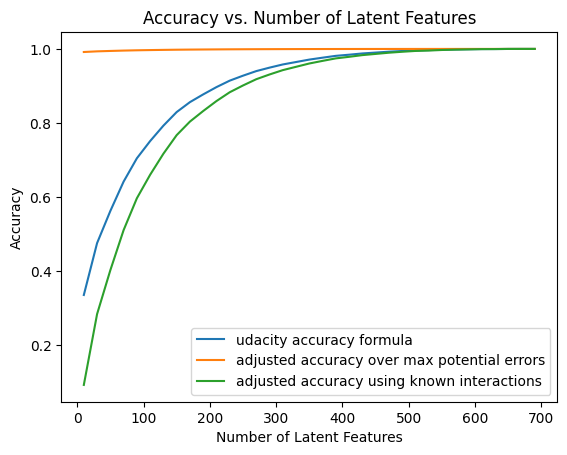

In [510]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0], label='udacity accuracy formula');
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(user_item_matrix.shape[0] * user_item_matrix.shape[1]), label='adjusted accuracy over max potential errors');
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(user_item_matrix==1).sum().sum(), label='adjusted accuracy using known interactions');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.legend()
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [353]:
df.shape

(45993, 3)

In [511]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    user_item_train = create_user_item_matrix(df_train)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [512]:
# user_item matrices have same columns in train an test sets
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [513]:
print("users which are both in train and test set for which we could make predictions for = ",len(set(user_item_test.index).intersection(user_item_train.index)))

users which are both in train and test set for which we could make predictions for =  20


In [514]:
print(user_item_test.shape)

(682, 574)


In [515]:
print(f'There are {user_item_test.shape[0] - len(set(user_item_test.index).intersection(user_item_train.index))} users for which we are not able to make predictions for because of the cold start problem')

There are 662 users for which we are not able to make predictions for because of the cold start problem


The articles in the test set are all present in the train set. We can make predictions on all of these test set articles. No "cold start" issue on the article_ids

In [377]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [595]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [596]:
print("u_train is of shape:", u_train.shape)
print("s_train is of shape:", s_train.shape)
print("vt_train is of shape:", vt_train.shape)

u_train is of shape: (4487, 4487)
s_train is of shape: (714,)
vt_train is of shape: (714, 714)


In [555]:
# To make predictions and compare to test set,
# Let's adjust to the test set perimeter: common user_ids and common article_ids
common_ids_idx = user_item_train.index.isin(test_idx)
common_arts_idx = user_item_train.columns.isin(test_arts)

u_train_subset = u_train[common_ids_idx,:]
vt_train_subset = vt_train[:,common_arts_idx]

In [556]:
print(u_train_subset.shape, vt_train_subset.shape)

(20, 4487) (714, 574)


In [566]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

# select a subset of the test data with the user_ids in commom with train set
# we find back the 20 users in common
common_user_ids = list(set(user_item_test.index).intersection(user_item_train.index))
common_art_ids = list(set(user_item_test.columns).intersection(user_item_train.columns))
test_subset = user_item_test.loc[common_user_ids,common_art_ids]
test_subset.shape

(20, 574)

Let's now use the SVD components trained on the train set to predict the user_item interaction matrix of the test set

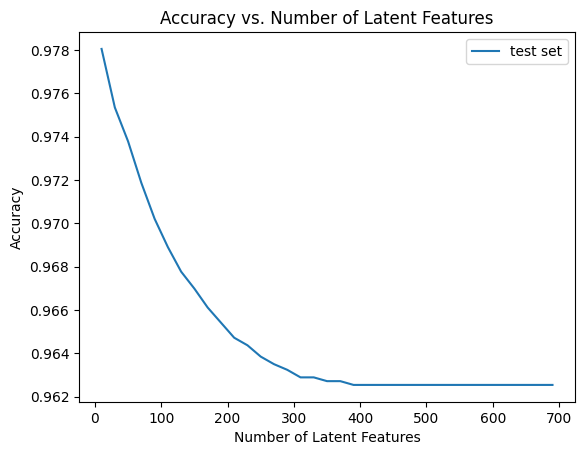

In [570]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features using adjusted SVD components
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train_subset[:, :k], vt_train_subset[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # compute error for each prediction to actual value of test set
    diffs = np.subtract(test_subset, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


plt.plot(num_latent_feats,
         1 - np.array(sum_errs)/(test_subset.shape[0] * test_subset.shape[1]),
         label='test set')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**
- The training was performed on a large dataset of 5149 users and 714 articles. Latent features learned the hidden relationships between these users and these articles (interactions).
- The model achieves a strong accuracy (above 96.2%) on predicting the small sample of 20 users in the test set, over the articles in common with the train set. The accuracy reduces as we increase the number of hidden features which can be interpreted as a sign of overfitting.
- The drawback of this recommendation approach is that we cannot make a recommendation for a new user or with new articles. For new users, a rank-based recommendation with top articles with highest interactions would be suitable.
- For existing users, we can definitely use the matrix factorization approach and predict likely interactions on existing articles.
- Special care should be taken with new articles. These should be promoted when added to the platform so that to gain interactions. Content similarity measure could be used to identify closest pool of articles leading to push these new articles to users interacting with this pool.
- To measure if such recommendation systems are an improvement to how users find articles, we could do a A/B test with an experiment group being proposed the new recommendation engines.

### Let's see if we can improve model by enlarging the common base between train and test sets

In [602]:
# reminder: count unique ids
print(df.user_id.nunique(), df.article_id.nunique())

5149 714


In [603]:
# find rows with identical user ids
duplicated_boolean = df.duplicated(subset='user_id')
duplicated_records_idx = df.loc[duplicated_boolean, :].index.tolist()
# find rows with identical article ids
duplicated_boolean = df.duplicated(subset='article_id')
# collect row indexes with duplicated user_ids and articles_ids
test_candidate_idx = set(duplicated_records_idx).intersection(df.loc[duplicated_boolean, :].index.tolist())
len(test_candidate_idx)

40340

In [617]:
# random select 13% of the train set within rows ensuring common users and articles with train set
# this is the similar proportion as earlier
test_idx = random.sample(list(test_candidate_idx), round(len(df)*0.13))
len(test_idx)

5979

In [618]:
# prepare new train and test sets constructed such as to maximize common ids
test_df = df.iloc[test_idx,:]
train_df = df.iloc[[i for i in range(len(df)) if i not in test_idx],:]
print('shape of train and test sets')
train_df.shape, test_df.shape

shape of train and test sets


((40014, 3), (5979, 3))

In [619]:
# prepare user_item matrices
user_item_train_, user_item_test_, test_idx_, test_arts_ = create_test_and_train_user_item(train_df, test_df)
print('shape of train and test user_item matrices')
user_item_train_.shape, user_item_test_.shape

shape of train and test user_item matrices


((5149, 714), (2054, 559))

In [620]:
# fit SVD on the user_item_train matrix
u_train_, s_train_, vt_train_ = np.linalg.svd(user_item_train_)
print("u_train is of shape:", u_train_.shape)
print("s_train is of shape:", s_train_.shape)
print("vt_train is of shape:", vt_train_.shape)

u_train is of shape: (5149, 5149)
s_train is of shape: (714,)
vt_train is of shape: (714, 714)


In [621]:
# find common users and articles shared between train and test sets
common_ids_idx = user_item_train_.index.isin(test_idx_)
common_arts_idx = user_item_train_.columns.isin(test_arts_)

print('Number of shared user_ids', common_ids_idx.sum())
print('Number of shared article_ids', common_arts_idx.sum())

# adjust SVD components on common elements
u_train_subset_ = u_train_[common_ids_idx,:]
vt_train_subset_ = vt_train_[:,common_arts_idx]
print(u_train_subset_.shape, vt_train_subset_.shape)

Number of shared user_ids 2054
Number of shared article_ids 559
(2054, 5149) (714, 559)


- We see we can now expect to predict on 2054 users and across 559 articles !

In [622]:
# Adjust test set to users in common with train set
common_user_ids = list(set(user_item_test_.index).intersection(user_item_train_.index))
common_art_ids = list(set(user_item_test_.columns).intersection(user_item_train_.columns))
test_subset_ = user_item_test_.loc[common_user_ids,common_art_ids]
test_subset_.shape

(2054, 559)

- predict and test accuracy

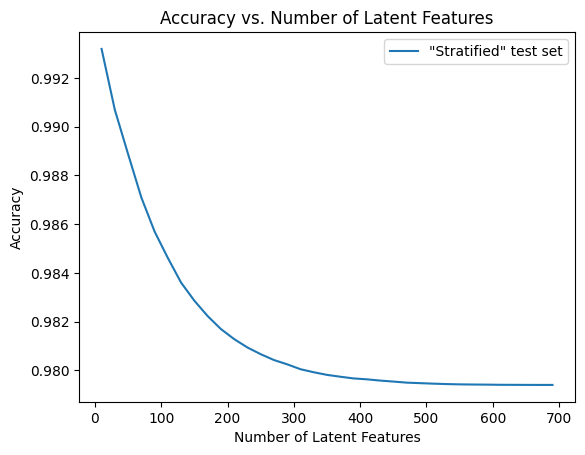

In [623]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features using adjusted SVD components
    s_new, u_new, vt_new = np.diag(s_train_[:k]), u_train_subset_[:, :k], vt_train_subset_[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # compute error for each prediction to actual value of test set
    diffs = np.subtract(test_subset_, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


plt.plot(num_latent_feats,
         1 - np.array(sum_errs)/(test_subset_.shape[0] * test_subset_.shape[1]),
         label='"Stratified" test set')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Number of Latent Features');

CONCLUSION: 
- by ensuring a kind of "stratified" approach for preparing the test set, we were able to significantly increase the number of users and scope of articles for prediction.
- Accuracy improves up to 98%+ across a larger scope of the dataset

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])